# Linear-nonlinear coupled problem with non-linear reaction

## This script contains the following: 

* Models a linear-nonlinear coupled problem with non-linear reaction
* Solves the problem using FEM
* Constructs the hybrid-NL and surrogate-NL
* Gives performance results regarding relative error and computation time

## Problem description

Consider the unit square domain $\Omega=(0, \ 1) \times (0, \ 1)$ with

\begin{align}
    \overline{\Omega} = \bigcup_{i=1}^9 \overline{R}_i,
\end{align}

where $R_i$ is a subregion with thermal conductivity $\mu_i >0$. The corresponding boundary $\partial \Omega$ is decomposed into four parts such that $\overline{\partial \Omega}=\overline{\Gamma_T \cup \Gamma_B \cup \Gamma_L \cup \Gamma_R}$.

Let $\mathcal{N}_R$ be a non-linear diffusion operator given by
\begin{align}
\label{eq:diffusion operator}
    \mathcal{N}_R u = -\nabla \cdot (k({x};{\mu})\nabla u) + R(u;\mu)
\end{align}

with $R({x};{\mu}) = \mu_{10}u(1+u^2) \mathbb{1}_{R_5}({x})$ where $\mathbb{1}_{R_5}({x})$ denotes the indicator function with respect to $R_5$ and the conductivity field

\begin{align}
\label{eq:tbc2}
     k({x}; {\mu}) = \sum_{i=1}^9 \mu_i \mathbb{1}_{R_i}({x}) \ \ \ \text{with} \ \ \ {\mu} = [\mu_1 \ \mu_2 \ ... \ \mu_{10}]^T \in \mathcal{P} = [0.1 \ 1]^9 \times [0.01 \ 10].
\end{align}  

The problem of interest is a steady-state Poisson problem given by

\begin{align}
    \begin{cases}
               -\mathcal{N}_R u= -6 & \text{in} \ \ \ \Omega, \\
    u= 1+x^2+2y^2 & \text{on} \ \ \ \Gamma_L \cup \Gamma_R, \\
    \frac{\partial u}{\partial {n}} = 4y & \text{on} \ \ \ \Gamma_T \cup \Gamma_B, \\
    \end{cases}
    \label{eq:tbc}
\end{align}
to be solved for $u(x;\mu)$ for all $\mu \in \mathcal{P}$.

# Import libraries and load functions

In [2]:
%run functions.ipynb

# Sample FOM solution

2 snapshots computed, 0 snapshots to go...
 
 Finished


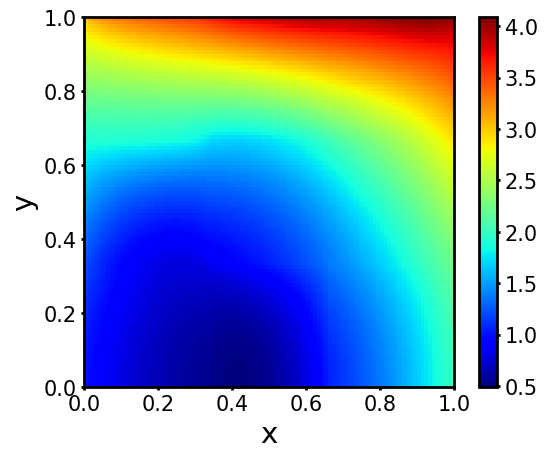

In [3]:
# Choose number of snapshots and test samples
ntest = 1
nsamples = 1 + ntest

# Choose LL-coupled problem 1 or thermal block
start = time.time()
%run FOM_snapshots.ipynb
end = time.time()

online_FOM = end - start 

# Plot solution
U_to_figure(S[:,0],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)


# Offline stage

# Create FOM snapshots and 100 test samples

In [4]:
# Choose number of snapshots and test samples
ntest = 100
nsamples = 500 + ntest

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu_all, mu_lin, mu_nlin,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu_all, mu_lin, mu_nlin,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl = pickle.load(file)

# Perform POD analysis

Snapshot energy domain 1: 0.9615473781732398
Snapshot energy domain 2: 0.9716428962619371
Snapshot energy interface: 0.9602596139358491


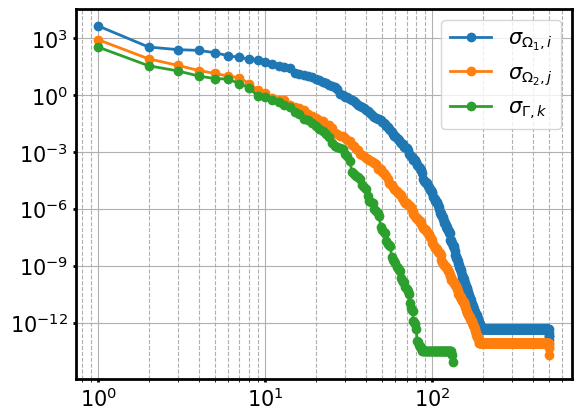

In [5]:
cutoff1 = 10
cutoffI = 5
cutoff2 = 5

start = time.time()
V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)
end = time.time()

POD_all_time = end - start

# Generate $\tilde{\mathcal{T}}_{n_s}$ and $\{ t_\Gamma(\mu^i)  \}_{i=1}^{n_s}$

In [6]:
a_1I_array = np.zeros((nsamples,ndofs_u1,ndofs_uI))
a_11_array = np.zeros((nsamples,ndofs_u1,ndofs_u1))
f_1_array = np.zeros((nsamples,ndofs_u1))

a_I1_array = np.zeros((nsamples,ndofs_uI, ndofs_u1))
a_II1_array = np.zeros((nsamples,ndofs_uI, ndofs_uI))
f_1I_array = np.zeros((nsamples,ndofs_uI))

traction_array34 = np.zeros((nsamples,ndofs_uI))
a1_tilde_array = np.zeros((nsamples,ndofs_uI,ndofs_uI))
f1_tilde_array = np.zeros((nsamples,ndofs_uI))

# Compute some precomputations

sV_1 = sps.csc_matrix(V_1)
sV_1T = sps.csc_matrix(V_1.T)

sV_I = sps.csc_matrix(V_I)
sV_IT = sps.csc_matrix(V_I.T)

start = time.time()

for i in range(nsamples):
    print(i+1, "precomputations done,",nsamples-i-1,"to go...", end="\r")
    
    if i == 0:
        start2 = time.time()

    a_1I = sV_1T*A_1I_array[i]*sV_I
    a_11 = sV_1T*A_11_array[i]*sV_1
    f_1 = sV_1T*F_1_array[i]

    a_1I_array[i] = a_1I.toarray()
    f_1_array[i] = f_1
    a_11_array[i] = a_11.toarray()
    
    if i == 0:
        end2 = time.time()
        online_m4_0 = end2-start2
        
        start3 = time.time()
    
    # ---- computation of traction force for method 3 ----
    
    
    a_I1 = sV_IT*A_I1_array[i]*sV_1
    a_II1 = sV_IT*A_II1_array[i]*sV_I 
    f_1I = sV_IT*F_1I_array[i]
    
    a_I1_array[i] = a_I1.toarray()
    a_II1_array[i] = a_II1.toarray()
    f_1I_array[i] = f_1I
    
    a1_tilde = a_II1-a_I1*sps.linalg.inv(a_11)*a_1I
    f1_tilde = a_I1*sps.linalg.inv(a_11)*f_1-f_1I
    traction = a1_tilde*uI[i]+f1_tilde
    
    if i == 0:
        end3 = time.time()
        online_m3_0 = end3-start3 + online_m4_0
    
    traction_array34[i] = traction
    a1_tilde_array[i] = a1_tilde.toarray()
    f1_tilde_array[i] = f1_tilde
    
    if i == nsamples-ntest:
        end = time.time()
        m3_partial_time = end-start   

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$

In [7]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    
    learning_rate = 0.1
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu_nlin[0:nsamples-ntest]))).float()

    u_2_models34 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.01
            
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34.append(u_2_model)
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34, time_u2_34]

    with open('u_2_models34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34.pkl', 'rb') as file:

        # Call load method
        u_2_models34, time_u2_34 = pickle.load(file)

# Train neural network $\hat{t}_\Gamma$

In [8]:
alreadyrun = 1

if not alreadyrun:

    traction_output = (traction_array34[:nsamples-ntest])

    # Train NN for traction force
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu_nlin[0:nsamples-ntest]))).float()

    traction_torch_outputs = torch.from_numpy(traction_output).float()

    n_epochs = 1000 
    learning_rate = 0.0005

    print("Trianing a Neural Network for the traction force...")
    traction_model34, traction_time34, loss = Neural_Network(torch_inputs, traction_torch_outputs, n_epochs, learning_rate)
    
    # Open a file and use dump()
    variables = [traction_model34, traction_time34]

    with open('traction_model34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('traction_model34.pkl', 'rb') as file:

        # Call load method
        traction_model34, traction_time34 = pickle.load(file)

# Train neural network for $\hat{\pi}_\Gamma$

In [9]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu_all[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()

    uI_model4, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    variables = [uI_model4, uI_model4time]


    with open('ugamma4.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4.pkl', 'rb') as file:

        # Call load method
        uI_model4, uI_model4time = pickle.load(file)

# Offline computation times

In [10]:
off3 = snapshots_time + POD_all_time + m3_partial_time + m3_time_train + time_u2_34 + traction_time34
off4 = snapshots_time + POD_all_time + time_u2_34 + uI_model4time

print('Offline computation time hybrid-NL:', off3)
print('Offline computation time surrogate-NL:',off4)

Offline computation time hybrid-NL: 353.7040777206421
Offline computation time surrogate-NL: 298.32888007164


# Online stage

# Hybrid-NL

In [11]:
h = 1e-5
threshold = 1e-7
gamma = 1e-1

rel_d1_m3 = np.zeros((ntest))
rel_d2_m3 = np.zeros((ntest))

rel_dI_m3 = np.zeros((ntest))
rel_all_m3 = np.zeros((ntest))

online_m3 = np.zeros((ntest))
sol_m3 = np.zeros((ntest,np.size(S[:,1])))
nmodes = 1

# Loop through test samples
test_samples2 = []
    
for j in range(ntest):
    print("Online stage: test sample",j,end="\r")

    start = time.time()
    
    which = nsamples-ntest+j

    mu_test_all = mu_all[which]
    mu_test_nlin = mu_nlin[which] 
    
    uI_exact = uI[which]

    # Determine the reduced vector on the interface
    initial, norm, mu_start = find_initial_condition(mu_nlin, mu_test_nlin, uI, nsamples, ntest)
    u_I_pred_m3, delta_norm, fk, count, residuals = newdescent(initial, mu_test_nlin, h, gamma, a1_tilde_array[which], f1_tilde_array[which], threshold, traction_model34)
     
    # Determine the reduced vector on domain 2
    u_2_pred = []

    # collect relative errors domain 2
    samples2 = []

    for i in range(int(cutoff2/nmodes)):

        mode = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m3,mu_test_nlin))).float()).detach().numpy()
        u_2_pred.append(mode[0])
        
        
    u_2_predh = np.matmul(V_2,u_2_pred)
    u_I_predh = np.matmul(V_I,u_I_pred_m3)
    
    u_1_pred = np.matmul(np.linalg.inv(a_11_array[which]),f_1_array[which]-np.matmul(a_1I_array[which],u_I_pred_m3))
    u_1_predh = np.matmul(V_1,u_1_pred)
    U_pred = np.hstack((u_1_predh,u_2_predh,u_I_predh))
    
    end=time.time()
    online_iter = end - start + online_m3_0
    online_m3[j] = online_iter

    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)
    sol_m3[j] = U_pred

    
    rel_d1_m3[j] = rel_error_1_1
    rel_d2_m3[j] = rel_error_2_1
    rel_dI_m3[j] = rel_error_I_1
    
    rel_all_m3[j] = rel_error_total_1   

# Surrogate-NL

In [12]:
rel_d1_m4 = np.zeros((ntest))
rel_d2_m4 = np.zeros((ntest))

rel_dI_m4 = np.zeros((ntest))
rel_all_m4 = np.zeros((ntest))

online_m4 = np.zeros((ntest))

sol_m4 = np.zeros((ntest,np.size(S[:,1])))


for j in range(ntest):
    print("Online stage: test sample",j,end="\r")

    start = time.time()
    which = nsamples-ntest+j

    mu_test = mu_all[which]
    mu_test_nlin = mu_nlin[which]
    
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()
    
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)
    
    uI_exact = uI[which]    
    u_2_pred_m4 = []

    for i in range(int(cutoff2/nmodes)):
        
        # method 2
        mode2 = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m4,mu_test_nlin))).float()).detach().numpy()
        u_2_pred_m4.append(mode2[0])
        
    u_2_predh_m4 = np.matmul(V_2,u_2_pred_m4)
    u_1_pred = np.matmul(np.linalg.inv(a_11_array[which]),f_1_array[which]-np.matmul(a_1I_array[which],u_I_pred_m4))
    u_1_predh = np.matmul(V_1,u_1_pred)
    
    U_pred = np.hstack((u_1_predh,u_2_predh_m4,u_I_predh_m4))
    end = time.time()
    
    online_iter = end - start + online_m4_0
    online_m4[j] = online_iter
    
    # Calculate relative errors
    U_exact = S[:,which]

    rel_error_1_1 = relative_error(U_exact[0:ndofs_U1],U_pred[0:ndofs_U1])
    rel_error_2_1 = relative_error(U_exact[ndofs_U1:ndofs_U1+ndofs_U2],U_pred[ndofs_U1:ndofs_U1+ndofs_U2])
    rel_error_I_1 = relative_error(U_exact[-ndofs_UI:],U_pred[-ndofs_UI:])

    rel_error_total_1 = relative_error(U_exact,U_pred)    
    sol_m4[j] = U_pred

    rel_d1_m4[j] = rel_error_1_1
    rel_d2_m4[j] = rel_error_2_1
    rel_dI_m4[j] = rel_error_I_1
    
    rel_all_m4[j] = rel_error_total_1

# Sample solutions using FOM, hybrid-NL and surrogate-NL

Relative error domain 1 method 3 0.03811974373745795
Relative error domain 2 method 3 0.04034661792087783
Relative error domain I method 3 0.06157419323355078
Relative error domain all method 3 0.03846234672295226
Relative error domain 1 method 4 0.028942787569935766
Relative error domain 2 method 4 0.02315005384187256
Relative error domain I method 4 0.03316863062142384
Relative error domain all method 4 0.02873749827627581


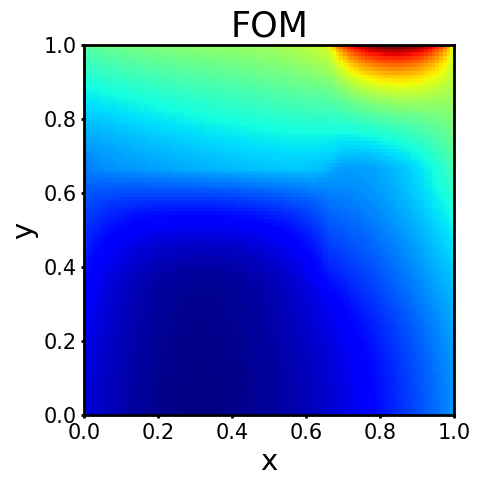

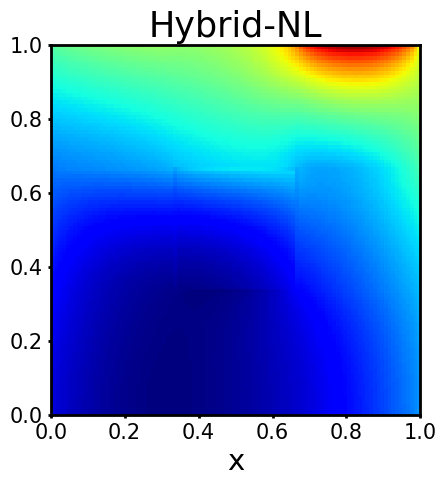

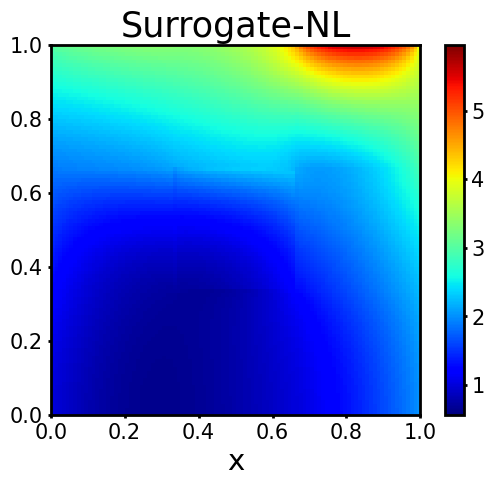

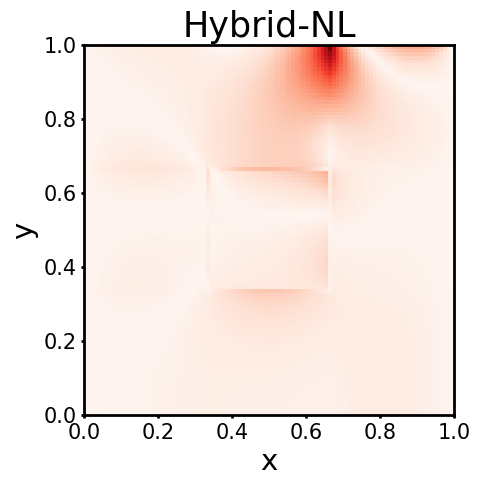

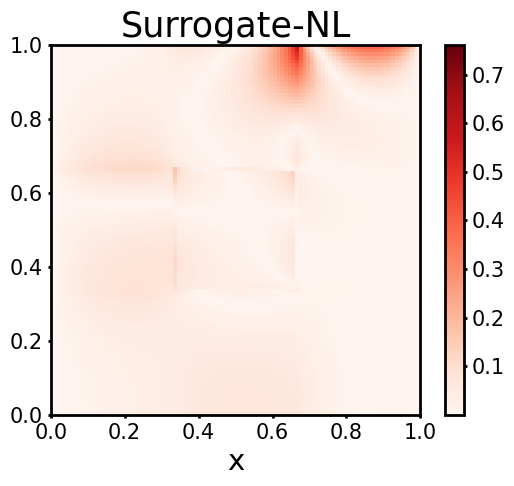

In [13]:
# Choose index between 0 and ntest
index = 11

print('Relative error domain 1 method 3',rel_d1_m3[index])
print('Relative error domain 2 method 3',rel_d2_m3[index])

print('Relative error domain I method 3',rel_dI_m3[index])
print('Relative error domain all method 3',rel_all_m3[index])

print('Relative error domain 1 method 4',rel_d1_m4[index])
print('Relative error domain 2 method 4',rel_d2_m4[index])

print('Relative error domain I method 4',rel_dI_m4[index])
print('Relative error domain all method 4',rel_all_m4[index])

fig0 = block_to_fig(S[:,index+nsamples-ntest],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig3 = block_to_fig(sol_m3[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig4 = block_to_fig(sol_m4[index,:],rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)

figs = [fig0, fig3, fig4]

vmax = -10
vmin = 10

for figure in figs:

    maxcandidate = max(figure.flatten())
    mincandidate = min(figure.flatten())

    if maxcandidate > vmax:
        vmax = maxcandidate

    if mincandidate < vmin:
        vmin = mincandidate 
        
titles = ['FOM', 'Hybrid-NL', 'Surrogate-NL']
saves = ['FOM_10', 'M310', 'M410']
saves_error = ['m310e', 'm410e']

# ----------------------------------- FOM and ROMs
for i in range(3):
    
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(figs[i] , vmin=vmin, vmax=vmax, interpolation = "nearest",extent=[0,1,0,1], cmap='jet')
    
    if i ==2:
        plt.colorbar()
    plt.title(titles[i])   
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
#     plt.savefig(saves[i], bbox_inches='tight')
    plt.show()
    
# ----------------------------------- Absolute errors
fig3 = block_to_fig(abs(sol_m3[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)
fig4 = block_to_fig(abs(sol_m4[index,:]-S[:,index+nsamples-ntest]),rows_domain1,rows_domain2,rows_interface,E_1,E_2,E_interface,mesh,gridsize)

figs = [fig3, fig4]

vmax = -10
vmin = 10

for figure in figs:

    maxcandidate = max(figure.flatten())
    mincandidate = min(figure.flatten())

    if maxcandidate > vmax:
        vmax = maxcandidate

    if mincandidate < vmin:
        vmin = mincandidate 
        
titles = ['Hybrid-NL', 'Surrogate-NL']

for i in range(2):
    plt.figure(figsize=(6.4, 4.8))
    plt.imshow(figs[i] , vmin=vmin, vmax=vmax, interpolation = "nearest",extent=[0,1,0,1], cmap='Reds')
    
    if i ==1:
        plt.colorbar()
    plt.title(titles[i])   
    
    plt.xlabel('x')
    if i == 0:
        plt.ylabel('y')
#     plt.savefig(saves_error[i], bbox_inches='tight')
    plt.show()



# Relative error figure

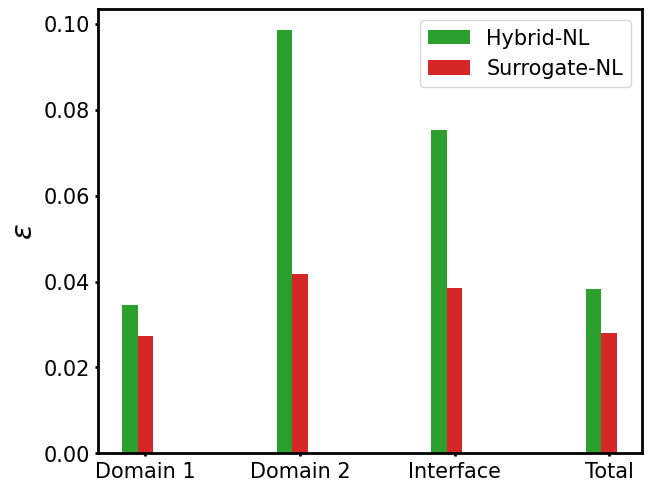

In [14]:
species = ("Domain 1", "Domain 2", "Interface", "Total")

penguin_means = {
    'Hybrid-NL': (np.mean(rel_d1_m3), np.mean(rel_d2_m3), np.mean(rel_dI_m3), np.mean(rel_all_m3)),
    'Surrogate-NL': (np.mean(rel_d1_m4), np.mean(rel_d2_m4), np.mean(rel_dI_m4), np.mean(rel_all_m4)),
}

x = np.arange(len(species))  
width = 0.1  

multiplier = 0
c = ['tab:green', 'tab:red']
fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    
    rects = ax.bar(x + offset, measurement, width, label=attribute,color=c[multiplier])
    multiplier += 1

ax.set_ylabel('$\epsilon$')
ax.set_xticks(x + width, species)

ax.legend(loc='upper right', ncols=1)
plt.savefig('rrelativerrors', bbox_inches='tight')
plt.show()

# Online CPU

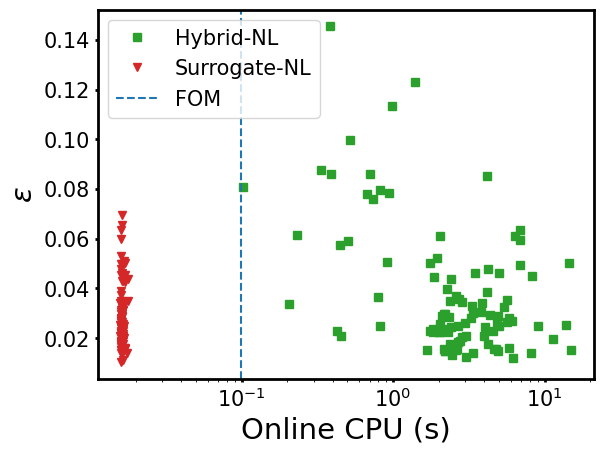

In [15]:
fig = plt.plot(online_m3, rel_all_m3, 's', color='tab:green', label='Hybrid-NL')
plt.plot(online_m4, rel_all_m4, 'v', color='tab:red', label='Surrogate-NL')
plt.axvline(x=online_FOM, linestyle='dashed', label='FOM')

plt.xlabel("Online CPU (s)")
plt.ylabel("$\epsilon$")
plt.xscale('log')

plt.legend()
plt.savefig('ronline', bbox_inches='tight')
plt.show()